# Numpy implementation

In [1]:
class NeuralNetwork:
    import numpy as np
    
    def __init__(self,  input_size, output_size, hidden_layers):
        # Initialize weights and biases
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = hidden_layers
        
        # initialise weights
        self.params = {}
        self.params = {
            "W1" : np.random.rand(self.input_size, self.hidden_layers) * np.sqrt(1/self.input_size),
            "b1" : np.zeros((1, self.hidden_layers)) * np.sqrt(1/self.input_size),
            "W2" : np.random.rand(self.hidden_layers, self.output_size) * np.sqrt(1/self.hidden_layers),
            "b2" : np.zeros((1, self.output_size)) * np.sqrt(1/self.hidden_layers)
        }

    def sigmoid(self, z):
        # Activation function
        # sigmoid = 1/(1+e^x)
        z = np.asarray(z)
        
        # handle overflow of numbers with e
        positives = (z >= 0)
        negatives = ~(positives)
        out = np.empty_like(z)
        out[positives] = 1/(1+np.exp(-(z[positives])))
        out[negatives] = np.exp(z[negatives])/(1+np.exp(z[negatives]))
        return out

    def sigmoid_derivative(self, z):
         # Derivative of sigmoid
        return z*(1-z)
    
    def softmax(self, z):
        # to avoid overflow in expotential subtract with max 
        exp_values = np.exp(z - np.max(z, axis = 1, keepdims = True))
        normalise_values = exp_values/ np.sum(exp_values, axis = 1, keepdims = True )
        
        return normalise_values
       

    def forward(self, X, y):
        # Forward pass through the network
        # Save intermediate values for backprop
        self.z1 = X.dot(self.params["W1"]) + self.params["b1"]
        self.a1 = self.sigmoid(self.z1)
        self.z2 = self.a1.dot(self.params["W2"]) + self.params["b2"]
        self.a2 = self.softmax(self.z2)
        return self.a2    

    
    def backward(self, X, y):
        # Backpropagation to calculate gradients
        current_batch_size = y.shape[0]
        dZ2 =  self.a2 - y
        dw2 = (1/current_batch_size)*(np.matmul(self.a1.T,dZ2 )  )
        db2 = (1/current_batch_size) * np.sum(dZ2, axis = 0, keepdims = True)
        dA1 = np.matmul( dZ2, self.params["W2"].T)
        dZ1 = dA1 * self.sigmoid_derivative(self.a1)
        dw1 = (1/current_batch_size) * np.matmul( X.T,dZ1)
        db1 = (1/current_batch_size) * np.sum(dZ1, axis = 0, keepdims = True)
        self.grads = {"W1" : dw1, "W2" : dw2 , "b1" : db1, "b2" : db2}
    
    def optimise(self, optimiser = 'sgd', learning_rate = 0.01, beta = 0.9):
        
        #optimiser  only SGD and momentum 
        if optimiser == "sgd" :
            for key in self.params:
                self.params[key] = self.params[key] - learning_rate * self.grads[key]
        elif optimiser == 'momentum':
            for key in self.params :
                self.momemtum_opt[key] = beta * self.momemtum_opt[key] + (1-beta) * self.grads[key]
                self.params[key] = self.params[key] - learning_rate * self.momemtum_opt[key]
        else:
            raise ValueError("Optimiser is currently not available please use SGD or Momentum")
            
    def cross_entropy(self, y, p):
        # Loss function 
        p = np.clip(p, 1e-12, 1-1e-12)
        return -np.sum(y * np.log(p)) / y.shape[0]
  
        
    def train(self, X, y, epoch = 5, learning_rate = 0.01, batch_size = 64, optimiser = 'sgd') :
        
        l = []
        self.batch_size = batch_size
        total_size = y.shape[0]
        num_batchs =total_size // self.batch_size
        
        if optimiser == 'momentum':
            self.momemtum_opt = {
                "W1": np.zeros(self.params["W1"].shape),
                "b1": np.zeros(self.params["b1"].shape),
                "W2": np.zeros(self.params["W2"].shape),
                "b2": np.zeros(self.params["b2"].shape),
            }
                
        for i in range(epoch):
            ## add permutation to shuffle data
            # perms = np.random.permutation(X.shape[0])
            # X = X[perms]
            # y = y[perms]
            for j in range(num_batchs):
                start = j*batch_size 
                end = min(start + batch_size, total_size)
                X_batch = X[start : end]
                y_batch = y[start : end]
                output = self.forward(X_batch, y_batch)
                loss_sub = self.cross_entropy(y_batch, output)
                self.backward(X_batch, y_batch )
                self.optimise(optimiser = optimiser, learning_rate = learning_rate )
                
            print (' At the end Epoch : ', i, ' Loss : ', loss_sub )
                

    def predict_prob(self, X_test):
        output = self.forward(X_test, None)
        return output
    
    def predict(self, X_test):
        predict_probabilities  = self.predict_prob(X_test)
        return np.argmax(predict_probabilities, axis = -1)
    
    def accuracy(self, y, y_pred):  
        return np.sum( np.argmax(y , axis = -1) == y_pred)/ y.shape[0]
                
        

In [2]:
from sklearn.datasets import fetch_openml
import numpy as np
mnist_data = fetch_openml("mnist_784")
X = mnist_data["data"]
y = mnist_data["target"]

/Users/prathyusharatan/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)

In [4]:
# Normalise Data 

In [5]:
X /= 255.0

In [6]:
# np.random.seed(0)

# X = np.array([[0.5,0.9],[0.11,0.21],[0.45,0.86],[0.5,0.9],[0.11,0.21],[0.45,0.86],[0.5,0.9],[0.11,0.21],[0.45,0.86],[0.5,0.9],[0.11,0.21],[0.45,0.86]])
# y = np.array([[1],[0],[1],[1],[1],[1],[1],[0],[1],[1],[1],[1]])

import numpy as np

X_train = np.array(X[:60000])
y_train = one_hot(y[:60000].astype(int), len(np.unique(y[:60000])))

input_size = X_train.shape[1]
output_size = y_train.shape[1]
hidden_layers = 64

model = NeuralNetwork(input_size, output_size, hidden_layers)
model.train(X_train, y_train , epoch = 5, learning_rate = 4, batch_size = 128, optimiser = "momentum")

X_test = np.array(X[60000:])
y_test = one_hot(y[60000:].astype(int), len(np.unique(y[60000:]))) 
preds = model.predict(X[60000:])
print('accuracy', model.accuracy(y_test, preds)*100)

/var/folders/xs/ryhm1w5n3y95mk12lz8x0dbw0000gq/T/ipykernel_97288/2753456165.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return np.array(x[:, None] == np.arange(k), dtype)


 At the end Epoch :  0  Loss :  0.03504593252991885
 At the end Epoch :  1  Loss :  0.026775186077354778
 At the end Epoch :  2  Loss :  0.019484080170790122
 At the end Epoch :  3  Loss :  0.016295579725452453
 At the end Epoch :  4  Loss :  0.014124290693005189
accuracy 96.09


# Tensorflow implementation

In [7]:
import tensorflow as tf 
import seaborn as sns
import keras 
import matplotlib.pylab as plt

In [8]:
X_train = np.array(X[:60000])
y_train = one_hot(y[:60000].astype(int), len(np.unique(y[:60000])))

/var/folders/xs/ryhm1w5n3y95mk12lz8x0dbw0000gq/T/ipykernel_97288/2753456165.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return np.array(x[:, None] == np.arange(k), dtype)


In [9]:

model = keras.Sequential([
                            keras.layers.Dense(64, activation = 'sigmoid'),
                            keras.layers.Dense(10, activation = 'softmax')]
                            
                            )
model.compile( optimizer= 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.fit(X_train, y_train, epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 1s 591us/step - loss: 0.4668 - accuracy: 0.8864
Epoch 2/5
1875/1875 [==============================] - 1s 585us/step - loss: 0.2216 - accuracy: 0.9370
Epoch 3/5
1875/1875 [==============================] - 1s 592us/step - loss: 0.1736 - accuracy: 0.9507
Epoch 4/5
1875/1875 [==============================] - 1s 584us/step - loss: 0.1436 - accuracy: 0.9579
Epoch 5/5
1875/1875 [==============================] - 1s 575us/step - loss: 0.1223 - accuracy: 0.9642


In [10]:
predictions = model.predict(X_test)
y_pred = [np.argmax(i) for i in predictions]

313/313 [==============================] - 0s 377us/step


In [11]:
y_test = np.array(y[60000:], dtype = 'int')

Text(95.72222222222221, 0.5, 'YPred')

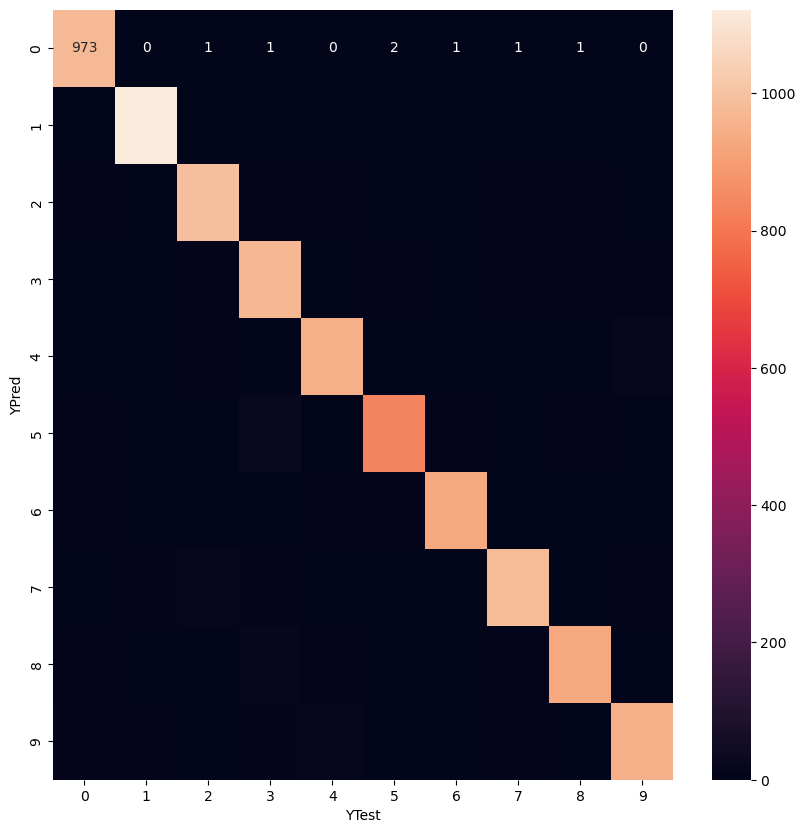

In [12]:
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm , annot = True , fmt ='d')
plt.xlabel('YTest')
plt.ylabel('YPred')